In [12]:
import gymnasium as gym
import math
import random
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt

In [13]:
env = gym.make("ALE/Breakout-v5")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
FIRE = 1

## Preprocessing

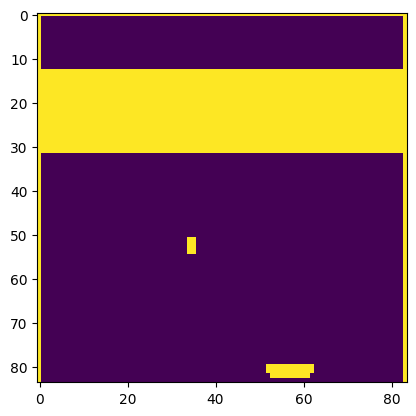

In [14]:
def pre_process(observe):
    processed_observe = np.uint8(resize(rgb2gray(observe)[31:-14,7:-7], (84, 84), mode='constant') * 255) > 0
    return processed_observe

state, info = env.reset()
obs, rwd, termin, trunc, info = env.step(FIRE)
obs, rwd, termin, trunc, info = env.step(FIRE)
obs, rwd, termin, trunc, info = env.step(FIRE)

plt.imshow(pre_process(obs))
plt.show()

## FF

In [15]:
class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]

    def predict(self, x):
        goodness_per_label = []
        for label in range(3):
            h = torch.tensor([x.tolist() + [label]], dtype=torch.float32)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)
    
    def is_good(self, x):
        goodness = []
        h = x.clone().detach()   # .tolist()
        for layer in self.layers:
            h = layer(h)
            goodness += [h.pow(2).mean(1)]
        return sum(goodness)

In [16]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.00003)
        self.threshold = 2.0
        self.num_epochs = 1

    def forward(self, x):
        # print(x.shape)
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4) # normalization
        # torch.mm -> matrix multiplication
        out = self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

        return out

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            out_pos = self.forward(x_pos)
            out_neg = self.forward(x_neg)
            g_pos = out_pos.pow(2).mean(1)
            g_neg = out_neg.pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([g_pos - self.threshold, -g_neg + self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=2)
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [17]:
from random import sample
from random import random

def hist_input(history):
    if history is not None:
        return torch.tensor(history > 0, dtype = torch.float, device=device)
    else:
        return history
        
def get_posneg_data(epsilon=0.5, N_neg=5):
    negative_data = []
    positive_data = []
    game_lens = []
    for i_episode in range(20):
        state, info = env.reset()
        obs, rwd, termin, trunc, info = env.step(FIRE)
        history = np.stack((pre_process(obs), pre_process(obs), pre_process(obs), pre_process(obs)))
        history = np.expand_dims(history, axis = 0)
        game = []
        rwd_tot = 0
        for t in count():
            s = random()
            if s > epsilon:
                action = env.action_space.sample()
            else:
                action = net.predict(torch.tensor(history.flatten())).item()
            obs, reward, terminated, truncated, _ = env.step(action)
            rwd_tot += reward
            done = terminated or truncated
            if terminated:
                next_state = None
                game.append(history.flatten().tolist() + [action])
            else:
                next_state = pre_process(obs)
                next_state = np.reshape([next_state], (1, 1, 84, 84))
                next_history = np.append(next_state, history[:, :3, :, :], axis = 1)
                game.append(history.flatten().tolist() + [action])
            state = next_state
            if done:
                break

        game_lens.append(rwd_tot)
        if len(game) > N_neg and not truncated:
            print(N_neg)
            negative_data += game[-int(N_neg):]
            positive_data += game[:-int(N_neg)]
        else:
            negative_data += game
    mean_len=sum(game_lens)/20
    print(mean_len)
    pos_len = len(positive_data)
    neg_len = len(negative_data)
    print(pos_len)
    print(neg_len)
    
    if pos_len > neg_len:
        positive_data = sample(positive_data, neg_len)
    else:
        negative_data = sample(negative_data, pos_len)

    return torch.tensor(positive_data, dtype=torch.float32), torch.tensor(negative_data, dtype=torch.float32), mean_len

In [18]:
net = Net([4*84*84+1, 300, 300])
env = gym.make("ALE/Breakout-v5") 
n_iters = 30

mean_lens = []

for i in range(n_iters):
    m = 100
    eps = 0.8*(1-i/n_iters)
    pos_data, neg_data, res = get_posneg_data(epsilon=eps, N_neg=m) # , look_next = l_n, thresh=0.2
    mean_lens.append(res)
    net.train(pos_data, neg_data)

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.7
2877
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.70it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
2.25
3651
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
2.15
3310
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.08it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.65
2763
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.37it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
2.25
3121
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.72it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.6
2456
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.72it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.55
2489
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.78it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
2.2
2832
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.5
2370
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.17it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.8
2527
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.80it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.85
2561
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
2.05
2665
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.78it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.9
2362
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.73it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.5
2104
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.49it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.7
2151
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.15
1347
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.36it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.6
1568
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.82it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.0
1287
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.17it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.55
1659
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.95it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
0.95
1201
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.21it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.55
1679
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.78it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.0
1269
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.59it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
2.0
2166
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.15
1488
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.41it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.75
2003
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.68it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.6
1868
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.64it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.0
1324
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.40it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.5
1890
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.49it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1.3
1573
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.31it/s]


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
2.2
2364
2000
training layer 0 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


training layer 1 ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.07it/s]


In [10]:
print(mean_lens)
print(len(mean_lens))

[0.9, 0.8, 0.75, 1.2, 0.9, 1.15, 1.35, 1.35, 1.3, 1.6, 1.65, 1.15, 1.15, 1.85, 1.45, 1.5, 1.05, 1.25, 1.2, 1.55, 1.4, 1.2, 1.2, 1.25, 1.45, 1.3, 1.35, 1.0, 1.5, 1.2]
30


N=100

[1.05, 0.5, 0.85, 0.85, 1.35, 1.45, 1.25, 0.8, 1.0, 1.35, 1.6, 0.85, 1.15, 1.4, 1.55, 1.2, 1.4, 1.3, 1.5, 1.35, 1.65, 1.25, 1.45, 0.95, 1.25, 1.75, 1.6, 1.35, 1.6, 1.2, 1.15, 1.3, 1.5, 0.95, 1.05, 1.2, 1.05, 1.25, 1.3, 1.75, 1.7, 1.1, 1.8, 1.55, 1.5, 1.2, 1.0, 0.95, 1.75, 1.3]

60 games

[0.9, 0.8, 0.75, 1.2, 0.9, 1.15, 1.35, 1.35, 1.3, 1.6, 1.65, 1.15, 1.15, 1.85, 1.45, 1.5, 1.05, 1.25, 1.2, 1.55, 1.4, 1.2, 1.2, 1.25, 1.45, 1.3, 1.35, 1.0, 1.5, 1.2]

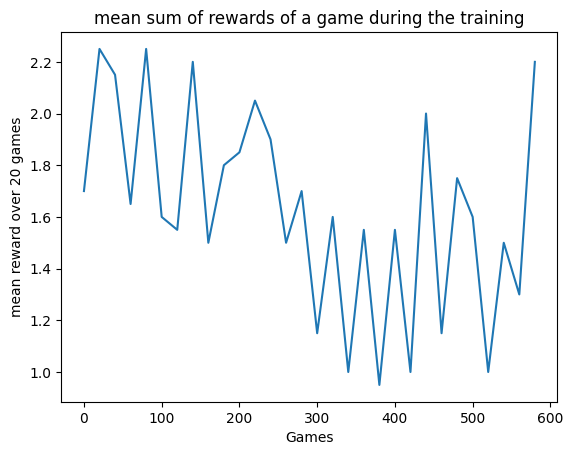

In [20]:
import matplotlib.pyplot as plt

# 30 % of game is negative
plt.plot(np.arange(0, 600, 20), mean_lens)
plt.title("mean sum of rewards of a game during the training")
plt.xlabel("Games")
plt.ylabel("mean reward over 20 games")
plt.show()